In [169]:
from pg_net import *
sess = tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))
net = PGNet(sess, seq_len=32, lr=0.0001, topn=3)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [181]:
import os
import pickle

data = {}
for f in os.listdir('data/genes'):
    data[f[:-2]] = pickle.load(open('data/genes/' + f, 'rb'), encoding='latin1')
    
labels = [x for x in data]
testing = ['LCE6A','RCOR3','KLHL20','GPR137B','USH2A','SMYD3',
           'CNIH3','CFHR2','WDYHV1','OPN3','TNN',
           'CAMK1G','LENEP','CYB5R1','EPHX1']
training = [x for x in labels if x not in testing]

val = []
tran = []
tran_times = []
val_times = []

In [182]:
disp = 8
print('Training:')
for x in training[:disp]:
    print(x, len(data[x]))
print(f'... {len(training) - disp} more')
print()
print('Validation:')
for x in testing[:disp]:
    print(x, len(data[x]))
print(f'... {len(testing) - disp} more')

Training:
HHAT 146
RASAL2 323
CKS1B 14
PEA15 36
SPRTN 119
PEX11B 78
OR6Y1 99
DPYS 135
... 927 more

Validation:
LCE6A 30
RCOR3 145
KLHL20 142
GPR137B 93
USH2A 1225
SMYD3 81
CNIH3 26
CFHR2 45
... 7 more


In [172]:
def get_time_top3(dataset):
    test_data = data[random.choice(dataset)]

    s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
    top3 = sorted(test_data, key=lambda x: x[1])[-3:]

    for i, (state, action, reward) in enumerate(zip(s, a, r)):
        best_seen = state[-1]# max(state, key=lambda x: x[1])
        if vec_dna(best_seen[0]) in [x[0] for x in top3]:
            return i
    return 20


In [82]:
from tqdm import trange
import random 
for i in trange(100):
    gene = random.choice(training)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    #%lprun -f SeqNet.multi_path net.train(samples, 10)
    tran.append(net.train(samples, 5, 16))
    gene = random.choice(testing)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    tran_times.append(get_time_top3(training))
    val_times.append(get_time_top3(testing))
    if i % 2 + 1:
        val.append(net.evaluate(samples, 5))
    else:
        val.append(val[-1])

  1%|          | 1/100 [00:04<07:55,  4.81s/it]


KeyboardInterrupt: 

In [162]:
net.sess.run(net.itr)

9912.0

In [174]:
# Save weights

saver = tf.train.Saver()
saver.save(net.sess, 'results/model.ckpt')

'results/model.ckpt'

In [126]:
def time_sim(dataset):
    res = []
    for i in dataset:
        var = [1, 1, 1] + [0 for j in range(len(data[i]) - 3)]
        random.shuffle(var)
        idx = min([20, var.index(1)])
        res.append(idx)
    return np.array(res).mean()

def reward_sim(dataset):
    res = []
    for i in dataset:
        clone = data[i][:]
        top3 = sorted(clone, key=lambda x: -x[1])[:3]
        for i in range(len(clone)):
            if clone[i] not in top3:
                clone[i] = (clone[i][0], 0)
        random.shuffle(clone)
        trajectory = clone[:20]
        trajectory = [i[1] for i in trajectory]
        res.append(np.array(trajectory).mean())
    return np.array(res).mean()


train_rand = np.array([time_sim(training) for i in trange(100)]).mean()
val_rand = np.array([time_sim(testing) for i in trange(100)]).mean()
train_rand_r = np.array([reward_sim(training) for i in range(100)]).mean()
val_rand_r = np.array([reward_sim(testing) for i in range(100)]).mean()
print('Training:', train_rand, train_rand_r)
print('Validation:', val_rand, val_rand_r)


100%|██████████| 100/100 [00:00<00:00, 462.39it/s]

Training: 13.707647058823529 0.031108054018553166
Validation: 12.65466666666667 0.03246476923123004


In [161]:
# Load weights

saver = tf.train.Saver()
saver.restore(net.sess, 'results/model.ckpt')

INFO:tensorflow:Restoring parameters from results/model.ckpt


In [173]:
# Save training data

pickle.dump(val, open('results/validation.p', 'wb'))
pickle.dump(tran, open('results/training.p', 'wb'))
pickle.dump(tran_times, open('results/tran_times.p', 'wb'))
pickle.dump(val_times, open('results/val_times.p', 'wb'))

In [185]:
import pickle
# Load old data

val = pickle.load(open('results/validation.p', 'rb'))
tran = pickle.load(open('results/training.p', 'rb'))
tran_times = pickle.load(open('results/tran_times.p', 'rb'))
val_times = pickle.load(open('results/val_times.p', 'rb'))

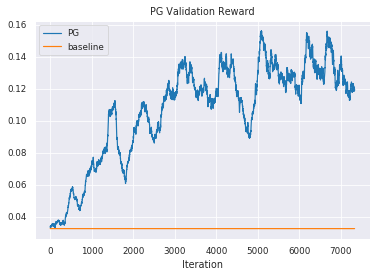

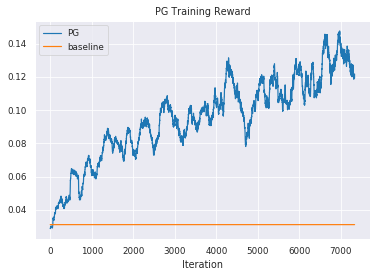

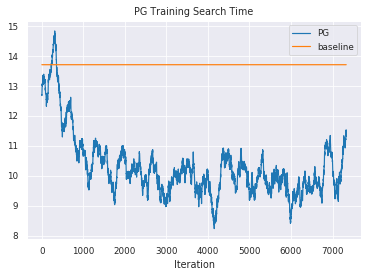

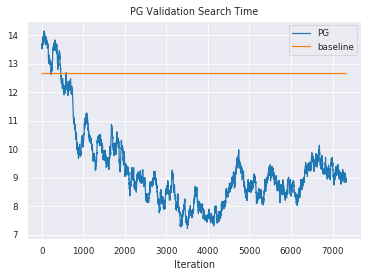

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')

gsmooth = 200
name='pg'
title='PG'

smooth = gsmooth
plt.title(f'{title} Validation Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth], label=title)
plt.plot([val_rand_r for _ in np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth]], label='baseline')
plt.legend()
plt.savefig(f'results/{name}-validation.png')
plt.show()

smooth = gsmooth
plt.title(f'{title} Training Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth], label=title)
plt.plot([train_rand_r for _ in np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth]], label='baseline')
plt.legend()
plt.savefig(f'results/{name}-training.png')
plt.show()

smooth = gsmooth
plt.title(f'{title} Training Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran_times, [1 / smooth] * smooth)[smooth:-smooth], label=title)
plt.plot([train_rand for _ in np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth]], label='baseline')
plt.legend()
plt.savefig(f'results/{name}-tran_time.png')
plt.show()

smooth = gsmooth
plt.title(f'{title} Validation Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(val_times, [1 / smooth] * smooth)[smooth:-smooth], label=title)
plt.plot([val_rand for _ in np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth]], label='baseline')
plt.legend()
plt.savefig(f'results/{name}-val_time.png')
plt.show()

In [158]:
test_data = data['RCOR3']
print('Avg rate:', np.array([i[1] for i in test_data]).mean())
s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
print('Avg reward:', np.array(r).mean())
print()
top3 = sorted(test_data, key=lambda x: x[1])[-3:]
done = 0

print('top 3')
for x in top3:
    print(*x)

print()
print('state\t\t\t\t\t', 'rate\t\t', 'proto\t\t\t\t\t', 'reward\t\t')
for i, (state, action, new_seq, reward) in enumerate(zip(s, a, ns, r)):
    best_seen = state[-1]# max(state, key=lambda x: x[1])
    print(vec_dna(best_seen[0]), '\t', '%.5f' % best_seen[1], '\t', vec_dna(action), '\t', '%.5f' % reward)
    if vec_dna(new_seq) in [x[0] for x in top3] and not done:
        print('', 'found!', vec_dna(new_seq))

Avg rate: 0.5058630044414518
Avg reward: 0.1473971545550022

top 3
TGCAAAGGAAAAGCATGGCTACAATGTGGAAC 0.705689012324376
CCTCCCCTGTTCTACCATGCCCGGCATGATGG 0.7425975024621626
GAAAATTAATGCCCGTTGGACCACAGAGGAGC 0.7570590738513432

state					 rate		 proto					 reward		
TCCCCCTCCCCTGTTCTACCATGCCCGGCATG 	 0.59130 	 CATTGCCCGTGCTGTATAGGTCACAGGCATAA 	 0.74260
 found! CCTCCCCTGTTCTACCATGCCCGGCATGATGG
CCTCCCCTGTTCTACCATGCCCGGCATGATGG 	 0.74260 	 TCAAGACGGTGAAGTATAGAACACGGGGTTCA 	 0.00000
CCAAGACCGGTGTTGTCCACGGTTGGTGGTCA 	 0.56210 	 TGACTTCAGCGAGTTATAGATCACAGCCGTCG 	 0.00000
CAGCCCCGGCCAACTTTAAATCAGCCTCCACC 	 0.52908 	 TCATTCCAGGGTTGGATACATCACAGCCCTGA 	 0.00000
AAACTACAGGCGTCGGTTTAACTTAGAGGAGG 	 0.39017 	 GAATGCCCTTGTTGTATATATCACGGCCGTCA 	 0.00000
CACTCCCTTTCCGGATGAGTGGACAGTGGAAG 	 0.69950 	 CGGGGCCCGTGTTCTATATACCACAGGGTTCG 	 0.00000
CATGCCACCCCGTCTAAACCCAAGACCGGTGT 	 0.59602 	 CCAAGGCGGTGAATTATATATCACGGGTCTCA 	 0.00000
CTACAGGCGTCGGTTTAACTTAGAGGAGGTAT 	 0.65426 	 TATGTCCCGTGAGCTAGAGATCACGGCCATCA 	 0.

In [ ]:
news = 0
total = 0
for i in trange(1):
    s, a, ns, r = net.path([(dna_vec(a), b) for a, b in test_data])
    for i, (state, action, reward) in enumerate(zip(s, a, r)):
        if (vec_dna(action) != "ATAACCCAGTGATCATTAATTCACTGCGTTGC"): 
            news += 1
            print(vec_dna(action))
        total += 1

print("{0}".format(news/total*100))